In [4]:
# loading in our raw data
raw = spark.read.options(header=True,inferSchema=True).csv('airplane_raw')


# only selecting columns which we need
# also, we do not want flights which were cancelled (only valid flights or delays)
filtered_raw = raw.where(raw.Cancelled == 0).select('Year','Month','DayofMonth','Origin','Dest',\
                                                       'ArrDelay','DepDelay','ActualElapsedTime','Distance')
print(raw.printSchema())
#filtered_raw = filtered_raw.repartition(15)
# Got 116684126 records
#print(filtered_raw.count())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carr

In [5]:
# joining latitude and longitude values to the dataset
airport_metadata = spark.read.options(header=True,inferSchema=True).csv('./airplane_raw/metadata/airports.csv')
print(airport_metadata.printSchema())

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Origin')\
                             .withColumnRenamed('lat','origin_lat')\
                             .withColumnRenamed('long','origin_long'), ['Origin'])

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Dest')\
                             .withColumnRenamed('lat','dest_lat')\
                             .withColumnRenamed('long','dest_long'), ['Dest'])

print(filtered_raw.printSchema())

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)

None
root
 |-- Dest: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)

None


In [6]:
# loading or mapping from (year,month,day,airport) to id
airport_date_to_id_mapping = spark.read.parquet('./airport_date_to_id_mapping')
print(airport_date_to_id_mapping.printSchema())



# loading mapping from id to weather conditions
id_to_weather_mapping = spark.read.parquet('./id_to_weather_mapping')
print(id_to_weather_mapping.printSchema())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- Airport: string (nullable = true)
 |-- id: long (nullable = true)

None
root
 |-- id: long (nullable = true)
 |-- ACSH: long (nullable = true)
 |-- WSFG: long (nullable = true)
 |-- WSFM: long (nullable = true)
 |-- SNOW: long (nullable = true)
 |-- TMAX: long (nullable = true)
 |-- SNWD: long (nullable = true)
 |-- PRCP: long (nullable = true)
 |-- AWND: long (nullable = true)
 |-- ACMH: long (nullable = true)
 |-- ACMC: long (nullable = true)
 |-- TMIN: long (nullable = true)

None


In [7]:
# dropping columns in the mapping which we do not need

final_weather_mapping = id_to_weather_mapping.select('id','PRCP','TMAX','TMIN','AWND')\
                                             .where(\
                                             (id_to_weather_mapping.PRCP!=-9999) &     \
                                             (id_to_weather_mapping.TMAX!=-9999) & \
                                             (id_to_weather_mapping.TMIN!=-9999) & \
                                             (id_to_weather_mapping.AWND!=-9999) \
                                             )
print(final_weather_mapping.count())



1336772


In [8]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

# mapping location and day,time to ids in the raw df
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Origin').withColumnRenamed('id','origin_id'), \
                                ['Year','Month','DayofMonth','Origin'])
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Dest').withColumnRenamed('id','dest_id'), \
                                ['Year','Month','DayofMonth','Dest'])

# adding a dayOfYear column
@F.udf(returnType = T.StringType())
def date_string(year,month,day):
    return year+'-'+month+'-'+day

# 12-2 is winter =0, 3-5 is spring=1, 6-8 is summer=2, 9-11 is fall=3
@F.udf(returnType = T.IntegerType())
def map_month_to_season(month):
    if month in {12,1,2}:
        return 0
    elif month in {3,4,5}:
        return 1
    elif month in {6,7,8}:
        return 2
    else:
        return 3


# dropping the year, month, dayofMonth, Origin,and Dest columns, since we have their unique ids
#filtered_raw = filtered_raw.withColumn('Date',F.concat_ws("-",filtered_raw.Year,filtered_raw.Month,filtered_raw.DayofMonth).cast("date"))
#filtered_raw = filtered_raw.withColumn('Date', F.dayofyear(filtered_raw.Date)).withColumnRenamed('Date','DayOfYear')
filtered_raw = filtered_raw.withColumn('Season',map_month_to_season(filtered_raw.Month))
filtered_raw = filtered_raw.drop('Year','Month','DayofMonth','Origin','Dest')
print(filtered_raw.printSchema())
print(filtered_raw.take(1))

root
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_id: long (nullable = true)
 |-- dest_id: long (nullable = true)
 |-- Season: integer (nullable = true)

None
[Row(ArrDelay='-1', DepDelay='-4', ActualElapsedTime='141', Distance='837', origin_lat=41.979595, origin_long=-87.90446417, dest_lat=29.99338889, dest_long=-90.25802778, origin_id=94489280720, dest_id=103079215211, Season=0)]


In [9]:
from math import isnan
# checking exactly how many records with weather that we have

# below collects map of (id -> [Weather conditions])
collect_weather = final_weather_mapping.rdd.map(lambda x: (x['id'],(x['PRCP'],x['TMAX'],x['TMIN'],x['AWND']))).collectAsMap()

collect_weather_broadcast = sc.broadcast(collect_weather)

# basically just grabbing records which are valid
def test_good_records(record):
    if record['ArrDelay'] == 'NA':
        return False
    elif record['DepDelay'] == 'NA':
        return False
    elif record['ActualElapsedTime'] == 'NA':
        return False
    elif record['Distance']=='NA':
        return False
    elif isnan(record['origin_lat']):
        return False
    elif isnan(record['origin_long']):
        return False
    elif isnan(record['dest_lat']):
        return False
    elif isnan(record['dest_long']):
        return False
    elif record['Season']==None:
        return False
    return True


filtered_raw = \
                filtered_raw.rdd\
                             .filter(test_good_records)\
                             .filter(lambda x: x['origin_id'] in collect_weather_broadcast.value \
                             and x['dest_id'] in collect_weather_broadcast.value).toDF()

#print(filtered_raw.where(filtered_raw.ArrDelay == 'NA').count())
#print(filtered_raw.where(filtered_raw.ActualElapsedTime == 'NA').count())
# 95830696
print(filtered_raw.count())
# turning string columns into ints, so we can run BFR

filtered_raw = filtered_raw\
                           .withColumn('ArrDelay',filtered_raw.ArrDelay.cast('int'))\
                           .withColumn('DepDelay',filtered_raw.DepDelay.cast('int'))\
                           .withColumn('ActualElapsedTime',filtered_raw.ActualElapsedTime.cast('int'))\
                           .withColumn('Distance',filtered_raw.Distance.cast('int'))



95830696


In [10]:
joined = filtered_raw.join(final_weather_mapping.withColumnRenamed('id','origin_id'),'origin_id')\
                     .withColumnRenamed('PRCP','origin_prcp')\
                     .withColumnRenamed('TMAX','origin_tmax')\
                     .withColumnRenamed('TMIN','origin_tmin')\
                     .withColumnRenamed('AWND','origin_awnd')\
                     .join(final_weather_mapping.withColumnRenamed('id','dest_id'),'dest_id')\
                     .withColumnRenamed('PRCP','dest_prcp')\
                     .withColumnRenamed('TMAX','dest_tmax')\
                     .withColumnRenamed('TMIN','dest_tmin')\
                     .withColumnRenamed('AWND','dest_awnd')\
                     .drop('dest_id','origin_id')

columns = joined.columns

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    
    joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
    
print(stats)

print(joined.take(1))

# lets write this data to parquet, just because
joined.write.parquet('./FINAL_processed_data')

Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.09965985734687, origin_long_mean=-92.27161607310381, dest_lat_mean=37.09915724194126, dest_long_mean=-92.26712071711091, Season_mean=1.4983448205364176, origin_prcp_mean=25.696228836739326, origin_tmax_mean=205.3709193033514, origin_tmin_mean=94.5765910747429, origin_awnd_mean=38.636158741871185, dest_prcp_mean=25.612486723460716, dest_tmax_mean=205.36587148443542, dest_tmin_mean=94.56188964755093, dest_awnd_mean=38.63819560488218, ArrDelay_stddev=30.939682127010034, DepDelay_stddev=28.437824166810316, ActualElapsedTime_stddev=70.31234179026464, Distance_stddev=569.0274209367312, origin_lat_stddev=5.599107569908235, origin_long_stddev=16.703784257869266, dest_lat_stddev=5.599707267313789, dest_long_stddev=16.697214735116148, Season_stddev=1.1130543679507328, origin_prcp_stddev=83.85304742810706, origin_tmax_stddev=105.31647

**Skip Pre-processing**

In [16]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import numpy as np
joined = spark.read.parquet('./FINAL_processed_data')

In [17]:
joined.printSchema()

root
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: double (nullable = true)
 |-- origin_prcp: double (nullable = true)
 |-- origin_tmax: double (nullable = true)
 |-- origin_tmin: double (nullable = true)
 |-- origin_awnd: double (nullable = true)
 |-- dest_prcp: double (nullable = true)
 |-- dest_tmax: double (nullable = true)
 |-- dest_tmin: double (nullable = true)
 |-- dest_awnd: double (nullable = true)



**Mini Batch Class**

In [18]:
import numpy as np
from sklearn.cluster import KMeans
class MiniBatch():
    def __init__(self,k):
        self.k = k
        self.N = np.zeros(k)
        self.centers = []
        
    def process_initial(self,sample):
        # in the first step, we can use some main memory algorithm to cluster a sample of points
        # lets just use k-means in sk learn library and then update our results
        model = KMeans(n_clusters=self.k).fit(sample)
        # creating our initial clusters
        self.centers = model.cluster_centers_
        for j in model.labels_:
            self.N[j] += 1
    
    # given a batch, we update the cluster centers and counts
    def process_batch(self, examples):
        for i,example in enumerate(examples):
            centroid_dist = np.zeros(self.k)
            for c in range(self.k):
                centroid_dist[c] = np.linalg.norm(example-self.centers[c])
            C = np.argmin(centroid_dist)
            self.N[C] = self.N[C] + 1
            lr = 1/self.N[C]
            self.centers[C] = ((1-lr) * self.centers[C]) + (lr * example)

**Mini Batch Loop**

In [19]:
joined = joined.withColumn('Season', joined.Season+2)
joined = joined.withColumn('Season', joined.Season.cast('int'))

In [20]:
season = 1
joined = joined.where(joined.Season == season).drop('Season')

In [23]:
k = 9
model = MiniBatch(k)

sample = joined.sample(fraction=0.0001).drop('batch_id')
#print(sample.printSchema())
test = sample.toPandas().to_numpy()
#print(test)

model.process_initial(test)
del(test)
del(sample)

In [24]:
joined = joined.withColumn('batch_id',F.spark_partition_id())
unique_partitions = joined.select('batch_id').distinct().rdd.map(lambda x: x['batch_id']).collect()
for i in unique_partitions:
    print('on batch partition: ' + str(i))
    batch = joined.filter(joined.batch_id == i).drop('batch_id').toPandas().to_numpy()
    print(len(batch))
    model.process_batch(batch)
    del(batch)

# writing to disk
with open('./MiniBatch_Clusters/season='+str(season)+'/num_clusters='+str(k)+'.txt','w+') as file:
    for i in range(k):
        file.write(str(model.centers[i])+'\nN: '+str(model.N[i])+'\n')

on batch partition: 0
41044
on batch partition: 1
48067
on batch partition: 2
471349
on batch partition: 4
1299960
on batch partition: 6
243165
on batch partition: 7
2373686
on batch partition: 8
182216
on batch partition: 9
194208
on batch partition: 10
1145134
on batch partition: 11
147682
on batch partition: 13
575976
on batch partition: 14
1747535
on batch partition: 15
1587158
on batch partition: 16
731800
on batch partition: 17
679983
on batch partition: 18
1733804
on batch partition: 19
882708
on batch partition: 20
2216277
on batch partition: 21
426467
on batch partition: 22
1267406
on batch partition: 23
759399
on batch partition: 24
839178
on batch partition: 25
368115
on batch partition: 26
688850
on batch partition: 27
1091585
on batch partition: 28
1309604
on batch partition: 29
739236
on batch partition: 30
369074
on batch partition: 31
341319


In [18]:
model.centers

array([[-5.54907360e-02, -3.96554666e-02, -3.29970063e-01,
        -3.01156369e-01, -7.24980529e-01, -3.05297133e-01,
        -4.27779029e-01, -2.58572097e-01,  6.73547675e-03,
        -2.72956939e-01, -3.40506683e-01, -1.49366471e-01,
         4.26902016e-03, -5.00154105e-01, -5.46061586e-01,
        -8.45035679e-02],
       [ 6.61442031e-02,  4.61507244e-02, -3.71092995e-01,
        -4.22549948e-01,  5.20395614e-01,  4.08608109e-01,
         5.55963390e-01,  4.28455942e-01, -8.10771554e-02,
        -1.53315806e+00, -1.46879213e+00,  2.60795428e-01,
        -8.29223876e-02, -1.56600068e+00, -1.50055397e+00,
         2.73861606e-01],
       [ 2.55737212e-01,  2.58013491e-01,  1.59968896e+00,
         1.56913364e+00,  2.52888821e-01, -2.55768112e-01,
        -4.58419777e-01, -3.96993089e-01,  2.05425917e-04,
        -1.04518556e+00, -9.44179370e-01,  1.15789181e-01,
         1.22431494e-02, -4.88564504e-01, -4.35693159e-01,
        -4.77478107e-02]])

In [32]:
len(model.centers)

9

**Generating Elbow Plots Using Squared Distance**

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def squared_error(centers, x):
    dist = np.zeros(len(centers))
    for c in range(len(centers)):
        dist[c] = np.linalg.norm(x-centers[c])
    return dist[np.argmin(dist)]**2

In [3]:
def obtain_centers(season, num_clusters):
    with open('./MiniBatch_Clusters/season='+str(season)+'/num_clusters='+str(num_clusters)+'.txt','r') as f:
        lines = f.readlines()
        centers = np.zeros((num_clusters,16))
        for i in range(num_clusters):
            centers[i] = lines[i*2][1:-2].split()
    return centers

In [5]:
for season in range(4):
    joined = spark.read.parquet('./FINAL_processed_data')
    joined = joined.withColumn('Season', joined.Season+2)
    joined = joined.withColumn('Season', joined.Season.cast('int'))
    joined = joined.where(joined.Season == season).drop('Season')
    errors = np.zeros(7)
    for k in range(3,10):
        centers = obtain_centers(season,k)
        errors[k-3] = joined.rdd.map(lambda x: squared_error(centers,x)).reduce(lambda x,y: x+y)
        print('Season = '+str(season)+', K = '+str(k)+', Error = '+str(errors[k-3]))
    with open('./MiniBatch_Errors/season='+str(season)+'.txt','w+') as file:
        file.write(str(errors))

Season = 3, K = 3, Error = 277424426.76895
Season = 3, K = 4, Error = 271881751.5396946
Season = 3, K = 5, Error = 241013555.88636246
Season = 3, K = 6, Error = 214329732.2368497
Season = 3, K = 7, Error = 206293428.51295635
Season = 3, K = 8, Error = 194014014.8384889
Season = 3, K = 9, Error = 186673353.3786316


In [4]:
def obtain_errors(season):
    with open('./MiniBatch_Errors/season='+str(season)+'.txt','r') as f:
        errors = np.array(f.readline()[1:-1].split()).astype('double')
    return errors

Text(0.5, 1.0, 'Mini Batch K-Means: Season=0')

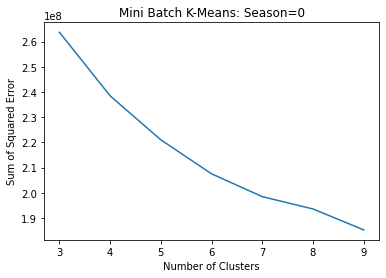

In [5]:
plt.plot([i for i in range(3,10)],obtain_errors(0))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.title("Mini Batch K-Means: Season=0")

**PCA for visualizing clusters**

In [6]:
joined = spark.read.parquet('./FINAL_processed_data')
joined = joined.withColumn('Season', joined.Season+2)
joined = joined.withColumn('Season', joined.Season.cast('int'))
season = 0
joined = joined.where(joined.Season == season).drop('Season')

In [11]:
center_5 = obtain_centers(0,5)

@F.udf(returnType = T.IntegerType())
def tag_record_5(x):
    dist = np.zeros(len(center_5))
    for c in range(len(center_5)):
        dist[c] = np.linalg.norm(np.array(x)-center_5[c])
    return int(np.argmin(dist))

In [12]:
from pyspark.sql.functions import struct, array
sample = joined.sample(fraction=0.0001)
#print(sample.printSchema())

sample = sample.withColumn("tag", tag_record_5(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()
#print(test)

In [20]:
test[:,:-1]

array([[-0.45766321, -0.35712245, -0.71280561, ...,  0.05347849,
        -0.22982034, -1.05154873],
       [-0.19909559, -0.14613585,  1.335199  , ...,  0.52807269,
         0.84991883, -0.95435497],
       [ 0.44732347,  0.66264614, -0.44258278, ..., -1.89235772,
        -1.29937329, -0.71137059],
       ...,
       [-0.16677463, -0.28679359,  0.63830854, ..., -0.58247773,
        -0.96322808, -0.75996747],
       [-0.03749082, -0.21646472, -0.10124868, ..., -1.47471482,
        -0.85117967,  0.30916382],
       [-0.06981177, -0.28679359, -0.74125012, ..., -0.52552643,
        -0.16870303, -0.03101431]])

In [26]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.23807975 0.19351987]
[96.37673757 86.8907944 ]


In [37]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

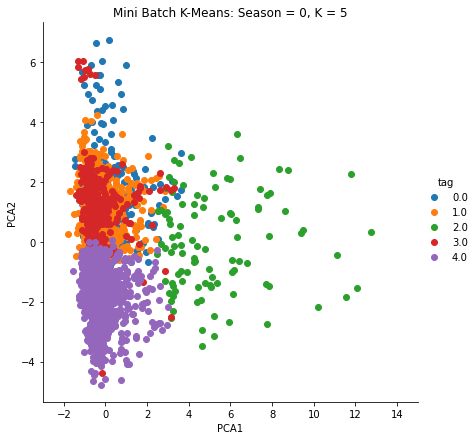

In [49]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()
plt.xlim(-3,15)
plt.title("Mini Batch K-Means: Season = 0, K = 5")
plt.show()